# Notebook for replicating figures from Drake et al. 2019 on the Abyssal Circulation

Note: may need to `build IJulia` in the anaconda environment that jupyter lab is launched from and `build NetCDF` before `using` it.

In [4]:
add_gsw = false
build_packages = false

if build_packages
    using Pkg
    Pkg.build("IJulia")
    Pkg.build("NetCDF")
end

dir = "../pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT

if add_gsw
    using Conda
    Conda.add("gsw")
end
gsw = pyimport("gsw");

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 200;

In [5]:
N = sqrt(1.5)*1.e-3
#layer_scale = mean(exp.(-((2500:100:5000)+z0)/1000)) # average of exponential decay of abyssal layer
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

dt = 2.e-5
dt_recip = Int(round(dt^-1))

#topo_col = (21./255.,30./255.,68./255.)
topo_col = (0.75,0.75,0.80);

PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;


# Sensitivity to friction $r$

ridge-0.6_del-0.4_r-0.25x
ridge-0.6_del-0.4_r-0.5x
ridge-0.6_del-0.4
ridge-0.6_del-0.4_r-2.0x
ridge-0.6_del-0.4_r-4.0x


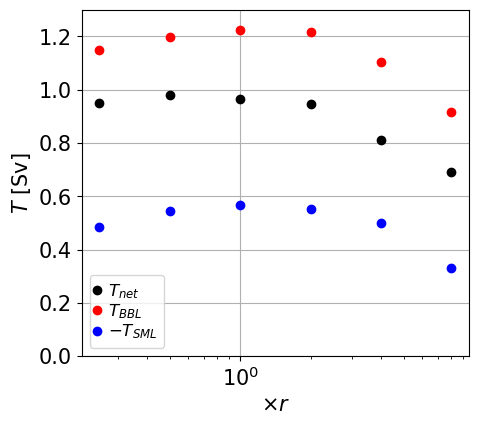

ridge-0.6_del-0.4_r-8.0x


In [12]:
dir = "../pgcm/"

strat = "ridge-0.6_del-0.4_r-"

rs = ["0.25", "0.5", "1.0", "2.0", "4.0", "8.0"]

expname = string(strat,rs[1], "x")
include(string(dir,expname,"/runs/equil/kernel.jl"))

nIter = dt_recip*50

nf = 40
del = 0.8

figure(figsize=(5,4.5))
subplot(1,1,1)
for (r_idx, r) in enumerate(rs)
    expname = string(strat,rs[r_idx],"x")
    if rs[r_idx] == "1.0"
        expname = strat[1:end-3]
    end
    println(expname)

    #------------------------  Load 3d Model data  ------------------------------
    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

    tht = -atan.(m.hxc)

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

    # Restoring
    Dr = -m.cc.*(s.bc .- m.bic)

    # Advective fluxes
    # get velocities
    Ux, Uy, Us = velocities(m,s.bc)
    # calculate advective fluxes
    hFx = m.hfx.*Ux.*ixcf(m,s.bc)
    hFy = m.hfy.*Uy.*iycf(m,s.bc)
    hFs = m.hc.*Us.*iscf(m,s.bc)

    # Advective flux divergence
    Du = zeros(size(s.bc))
    Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
    Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
    Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Advective flux divergences
    Dux = zeros(size(s.bc))
    Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

    Duy = zeros(size(s.bc))
    Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

    Dus = zeros(size(s.bc))
    Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Buoyancy tendency 
    s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
    dbdt = (s1.bc .- s.bc)/(m.dt*5000.)

    # Diagnose exact diffusive flux divergence as residual of other explicit terms
    Dk = dbdt .- (Du .+ Dr)

    sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

    x_fy,y_fy = 
    [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
    [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
    sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

    ## Calculate integral constraint based on mean angle at given depth
    tht = -atan.(m.hxc)

    # Calculate transport predicted by 1D theory
    psi_inf = tan.(maximum(abs.(tht[1,100:150,25:75])))^-1*minimum(m.kfs)*Tscale

    ###############    Water mass transformation     ##################
    mins = -1.1
    dsf = round(abs(mins/nf), digits=5)
    sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
    scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

    bf = del*(exp.(sf/del) .-1.)
    dbf = bf[2:end]-bf[1:end-1]
    bc = del*(exp.(scb/del) .-1.)
    dbc = bc[2:end]-bc[1:end-1]

    itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
    bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

    zc = zeros(nf)
    for i in 1:nf
        idx = bf[i] .< bcf .< bf[i+1]
        zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
    end
    zc[isnan.(zc)] .= -1.
    zc[end] = 0.

    ########################################
    zref = vcat(copy(zc),[0])
    bref = vcat(copy(bc)[:,1,1],[0])
    nref = length(bref)
    intD = zeros(size(bref))

    BBLmask = Dk.>0.
    for i=1:m.nx
        for j=1:m.ny
            BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
        end
    end

    labels = [
        L"$T_{net}$",
        L"$T_{BBL}$",
        L"$-T_{SML}$"
    ]


    flux_list = [
        Dk,
        Dk,
        Dk
    ]

    mask_list = [
        trues(size(Dk)),
        BBLmask,
        .~BBLmask
    ]

    colors = [
        "k",
        "r",
        "b"
    ]

    sign_flip = [
        1.,
        1.,
        -1.
    ]

    for flux_idx = 1:length(flux_list)
        # Transformations in 3D model
        tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

        intD = zeros(size(bref))
        for i=1:1:nref
            intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
        end
        T = diff(intD)./diff(bref) #*Tscale
        T[isnan.(T)] .= 0

        mm, ii = findmax(abs.(T))

        if (r_idx==1); label = labels[flux_idx]; else; label = nothing; end
        semilogx(parse(Float64,rs[r_idx]), sign_flip[flux_idx]*T[ii]*Tscale, label=label, color=colors[flux_idx], marker="o")
    end
end
xlabel(L"$\times r$")
ylabel(L"$T$ [Sv]")
grid(true)
ylim([0, 1.3])
legend(loc="lower left", labelspacing=0.1, handlelength=0, handletextpad=0.7, columnspacing=1.1, fontsize=12)

savefig(string("../figures/friction_scaling.png"),dpi=dpi,bbox_inches="tight")